In [1]:
import pandas as pd
from pandas import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt
%matplotlib inline
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error

In [2]:
# test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')
# test=pd.read_csv('/home/atif/dataset_26_april_3.csv')
test=pd.read_csv('E:/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

In [3]:
import datetime
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

C:\Users\atif\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [6]:
test_new = test_new.set_index('dateTime') # make dataTime column as index of the dataframe test_new

In [7]:
univariate_column_label=['DEWIHOBT9_I0','AEDAHO_T9_V2'] #target is turbine 9's input
# univariate_column_label=['DEWIHOBT9_I0','AEWIHO_T9AV2'] #target is turbine 9's output
univariate_data=test_new.iloc[2000:7000][univariate_column_label]
univariate_data=univariate_data.loc[::-1]

In [8]:
univariate_data.head()

,DEWIHOBT9_I0,AEDAHO_T9_V2
dateTime,,
2019-04-06 00:21:00,100.0,72.427071
2019-04-06 00:22:00,100.0,71.620643
2019-04-06 00:23:00,100.0,70.606738
2019-04-06 00:24:00,100.0,70.531626
2019-04-06 00:25:00,100.0,70.692115


In [9]:
zero_index=[]
zero_index=np.array(zero_index)
for index, value in univariate_data.iterrows():
    for i , v in enumerate(value):
        if i == 0  and v == 0.0:
#             print('index: ',index)
            zero_index=np.append(zero_index,index)

print('size of zero_index: ',zero_index.size)

size of zero_index:  0


In [10]:
if zero_index.size > 0:
    univariate_data_modify = univariate_data.drop(zero_index,axis=0) # axis= 0 means row indiated. 1 means column indicated
else:
    univariate_data_modify = univariate_data

In [11]:
univariate_data_modify = univariate_data_modify.drop(['DEWIHOBT9_I0'], axis=1)

In [12]:
univariate_data_modify.head()

,AEDAHO_T9_V2
dateTime,
2019-04-06 00:21:00,72.427071
2019-04-06 00:22:00,71.620643
2019-04-06 00:23:00,70.606738
2019-04-06 00:24:00,70.531626
2019-04-06 00:25:00,70.692115


# Drop any zero value present now in the dataset

In [13]:
from numpy import nan
univariate_data_drop_zero = univariate_data_modify.replace(0,nan)
univariate_data_drop_zero = univariate_data_drop_zero.dropna(how='any',axis=0)

4999
(4999, 1)
                     AEDAHO_T9_V2
dateTime                         
2019-04-06 00:21:00     72.427071
2019-04-06 00:22:00     71.620643
2019-04-06 00:23:00     70.606738
2019-04-06 00:24:00     70.531626
2019-04-06 00:25:00     70.692115


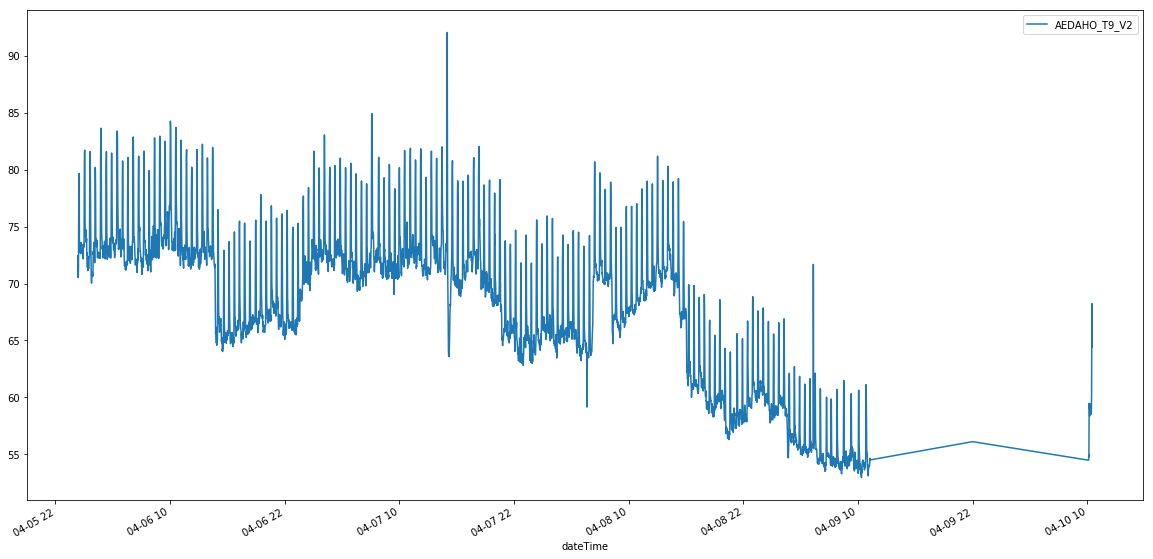

In [15]:
print(univariate_data_drop_zero.size)
print(univariate_data_drop_zero.shape)
print(univariate_data_drop_zero.head())

cx = univariate_data_drop_zero.plot()
# plt.legend(loc='upper left')
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

# Now we have to check the stationarity of the obtained dataset university_data_drop_zero
# https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
# Augmented Dickey Fuller test

In [34]:
for my_column_label in univariate_data_drop_zero.columns:
    print(my_column_label)

AEDAHO_T9_V2


In [35]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries,my_column_label):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[my_column_label], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
# adf_test(train['#Passengers'])
adf_test(univariate_data_drop_zero,my_column_label)

Results of Dickey-Fuller Test:
Test Statistic                   -0.489177
p-value                           0.894111
#Lags Used                       32.000000
Number of Observations Used    4966.000000
Critical Value (1%)              -3.431667
Critical Value (5%)              -2.862122
Critical Value (10%)             -2.567080
dtype: float64


# KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [38]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries, my_column_label):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries[my_column_label], regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(univariate_data_drop_zero,my_column_label)

Results of KPSS Test:
Test Statistic            9.805321
p-value                   0.010000
Lags Used                32.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\atif\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


# Making a Time Series Stationary

# Differencing, Seasonal Differencing, Transformation

# Differencing

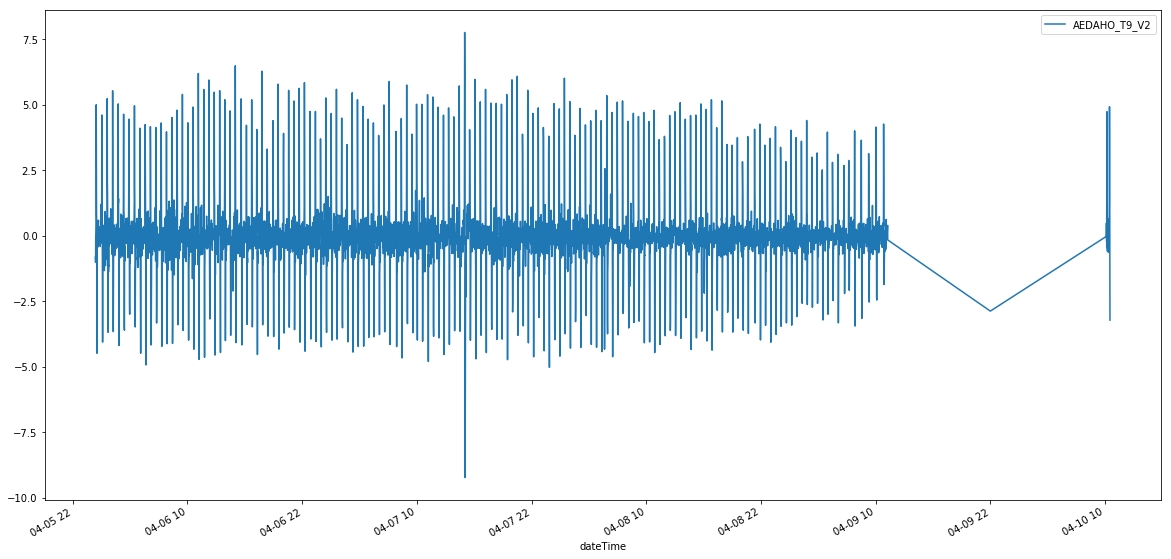

In [39]:
diff_univariate_data = univariate_data_drop_zero - univariate_data_drop_zero.shift(1)
diff_univariate_data.dropna().plot()

# Seasonal Differencing

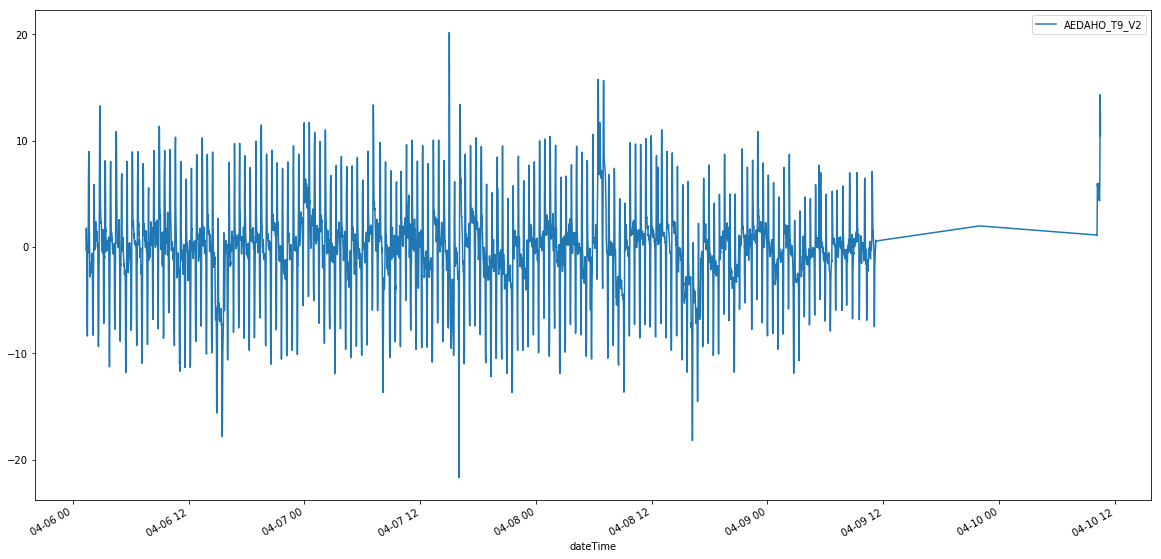

In [41]:
n=60
seasonal_univariate_data = univariate_data_drop_zero - univariate_data_drop_zero.shift(n)
# seasonal_univariate_data.dropna().plot()
seasonal_univariate_data.plot()

# Transformation

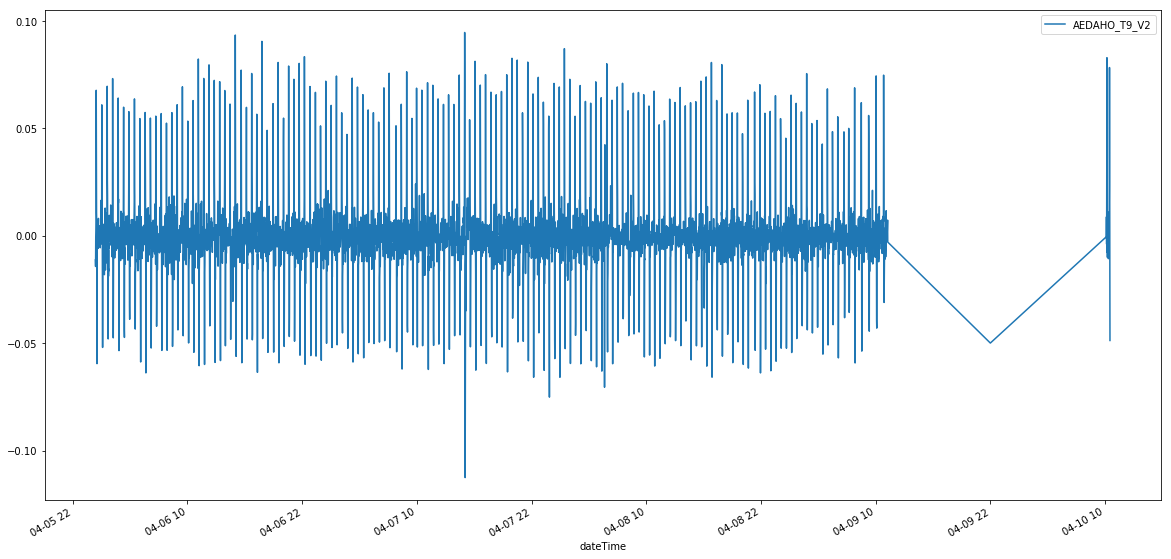

In [42]:
log_univariate_data = np.log(univariate_data_drop_zero)
diff_log_univariate_data = log_univariate_data - log_univariate_data.shift(1)
diff_log_univariate_data.dropna().plot()

In [13]:
# from matplotlib.pylab import rcParams
# print('shape of univariate_data: ',univariate_data.shape)
# univariate_data.plot()
# plt.rcParams['figure.figsize'] =(20,10)
# plt.show()

In [87]:
# from numpy import nan
# univariate_data_drop_zero= univariate_data.replace(0,nan)
# univariate_data_drop_zero= univariate_data_drop_zero.dropna(how='any',axis=0)

# univariate_data_drop_zero.plot()
# plt.show()

In [88]:
# dataset=univariate_data_drop_zero.values
# print(type(dataset))
# # print(dataset)
# print('length of dataset: ',len(dataset))

# check for zero value

In [14]:
# # zero_value=univariate_data.columns[univariate_data.isnull().any()]
# # univariate_data[zero_value].isnull().sum()

# for idx,val in enumerate(list(univariate_data.columns)):
#     count=1
#     for i, j in univariate_data.iterrows():
#         for k in j:
#             if k==0:
#                 count+=1
#                 print(i,'\t\t',k)

In [19]:
# zero_val=univariate_data_modify.loc[univariate_data_modify['AEDAHO_T9_V2']==0]
# print(zero_val.size)

# replace zero value with the mean value

In [16]:
# univariate_mean = univariate_data.mean()
# univariate_data_mean= univariate_data.replace(0,univariate_mean)
# print('univariate_data_mean : ',univariate_data_mean.head())

# Following cell will check is there any zero value present after replacing them with the mean value or not

In [17]:
# zero_val_now=univariate_data_mean.loc[univariate_data_mean['AEDAHO_T9_V2']==0]
# print(zero_val_now.size)

In [18]:
# univariate_data_mean.plot()
# plt.show()

# make train and test dataset array

In [20]:
def make_dataset(PandaDataframe):
    dataset = np.array(PandaDataframe)

    NumberOfElements = int(len(dataset)*0.9)
    print('dataset length: ',len(dataset))
    print('Number of Elements for training: ',NumberOfElements)

    train_data = dataset[0:NumberOfElements]
    test_data = dataset[NumberOfElements:len(dataset)]
    
    return train_data, test_data

train_set, test_set = make_dataset(univariate_data_drop_zero)
print('train_set shape: ', train_set.shape)
print('test_set shape: ', test_set.shape)

dataset length:  4999
Number of Elements for training:  4499
train_set shape:  (4499, 1)
test_set shape:  (500, 1)


In [35]:
Actual = [x for x in train_set]
Predictions = list()

In [36]:
#Function that calls ARIMA model to fit and forecast the data
def StartARIMAForecasting(Actual, P, D, Q):
#     print('from function screaming')
    model = ARIMA(Actual, order=(P, D, Q))
    model_fit = model.fit(disp=0)
#     save_model=model_fit.save('model_22.pkl')
    prediction = model_fit.forecast()[0]
    save_model=model_fit.save('model_22.pkl')
    return prediction,save_model

In [37]:
count_1=1
for timepoint in range(len(test_set)):
#     print('I am in for loop')
    ActualValue =  test_set[timepoint]
    #forcast value
    Prediction,save_model_1 = StartARIMAForecasting(Actual, 2,1,2) 
    print('count=%d, Actual=%f, Predicted=%f' % (count_1 ,ActualValue, Prediction))
    count_1+=1
    #add it in the list
    Predictions.append(Prediction)
    Actual.append(ActualValue)
    

count=1, Actual=61.315957, Predicted=60.631489
count=2, Actual=62.692824, Predicted=62.163768
count=3, Actual=61.682259, Predicted=62.685960
count=4, Actual=58.954713, Predicted=60.314237
count=5, Actual=57.320935, Predicted=57.001832
count=6, Actual=57.487585, Predicted=56.439466
count=7, Actual=56.978387, Predicted=57.717790
count=8, Actual=56.553797, Predicted=56.743153
count=9, Actual=56.781821, Predicted=56.479070
count=10, Actual=56.419114, Predicted=57.093413
count=11, Actual=56.447232, Predicted=56.352789
count=12, Actual=56.207781, Predicted=56.664642
count=13, Actual=56.028931, Predicted=56.253423
count=14, Actual=56.026364, Predicted=56.151034
count=15, Actual=56.244887, Predicted=56.253835
count=16, Actual=55.708339, Predicted=56.569221
count=17, Actual=55.728239, Predicted=55.593357
count=18, Actual=55.861252, Predicted=56.013564
count=19, Actual=55.768043, Predicted=56.160088
count=20, Actual=55.716431, Predicted=55.918804
count=21, Actual=55.559536, Predicted=55.907078
c

count=171, Actual=54.978694, Predicted=54.147106
count=172, Actual=54.437136, Predicted=55.549584
count=173, Actual=54.541649, Predicted=54.251835
count=174, Actual=54.337379, Predicted=54.831116
count=175, Actual=54.457168, Predicted=54.405244
count=176, Actual=54.194478, Predicted=54.734917
count=177, Actual=54.579396, Predicted=54.231445
count=178, Actual=54.835920, Predicted=55.003404
count=179, Actual=54.679800, Predicted=55.092179
count=180, Actual=54.718957, Predicted=54.689855
count=181, Actual=54.941074, Predicted=54.869780
count=182, Actual=55.069464, Predicted=55.163062
count=183, Actual=54.704450, Predicted=55.196810
count=184, Actual=54.339691, Predicted=54.561809
count=185, Actual=54.032064, Predicted=54.275412
count=186, Actual=54.055818, Predicted=54.045580
count=187, Actual=53.912530, Predicted=54.276846
count=188, Actual=53.886723, Predicted=54.019536
count=189, Actual=54.003686, Predicted=54.078954
count=190, Actual=54.254436, Predicted=54.258618
count=191, Actual=53

count=339, Actual=54.723835, Predicted=54.584005
count=340, Actual=54.708172, Predicted=54.967385
count=341, Actual=54.859032, Predicted=54.651150
count=342, Actual=54.632933, Predicted=54.915063
count=343, Actual=54.215278, Predicted=54.461603
count=344, Actual=54.599937, Predicted=54.002135
count=345, Actual=54.460890, Predicted=54.870137
count=346, Actual=54.152749, Predicted=54.357052
count=347, Actual=54.013447, Predicted=54.015121
count=348, Actual=54.255210, Predicted=54.014449
count=349, Actual=54.353042, Predicted=54.460442
count=350, Actual=55.008864, Predicted=54.424652
count=351, Actual=54.898831, Predicted=55.360012
count=352, Actual=54.580552, Predicted=54.725325
count=353, Actual=54.842728, Predicted=54.363405
count=354, Actual=55.416508, Predicted=54.980713
count=355, Actual=55.028249, Predicted=55.642288
count=356, Actual=54.415826, Predicted=54.660396
count=357, Actual=57.552167, Predicted=54.049382
count=358, Actual=60.257369, Predicted=59.212125
count=359, Actual=60

In [38]:
print('Actual type: ',type(Actual),' size: ',len(Actual))
print('Predictions type: ',type(Predictions),' size: ',len(Predictions))
print('test_set type: ',type(test_set),' size: ',len(test_set))

Actual type:  <class 'list'>  size:  4999
Predictions type:  <class 'list'>  size:  500
test_set type:  <class 'numpy.ndarray'>  size:  500


In [39]:
from sklearn.metrics import mean_squared_error

#Print MSE to see how good the model is
Error = mean_squared_error(test_set, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)

print("size of prediction: ",len(Predictions))
print("size of actual: ",len(Actual))

Test Mean Squared Error (smaller the better fit): 0.607
size of prediction:  500
size of actual:  4999


In [55]:
# loaded = ARIMAResults.load('model_22.pkl')
# loaded=save_model_1

In [56]:
# start_index = len(Actual)
# end_index = start_index + len(test_set)-1
# # forecast = model_fit.predict(start=start_index, end=end_index)
# forecast = loaded.predict(start=start_index, end=end_index)

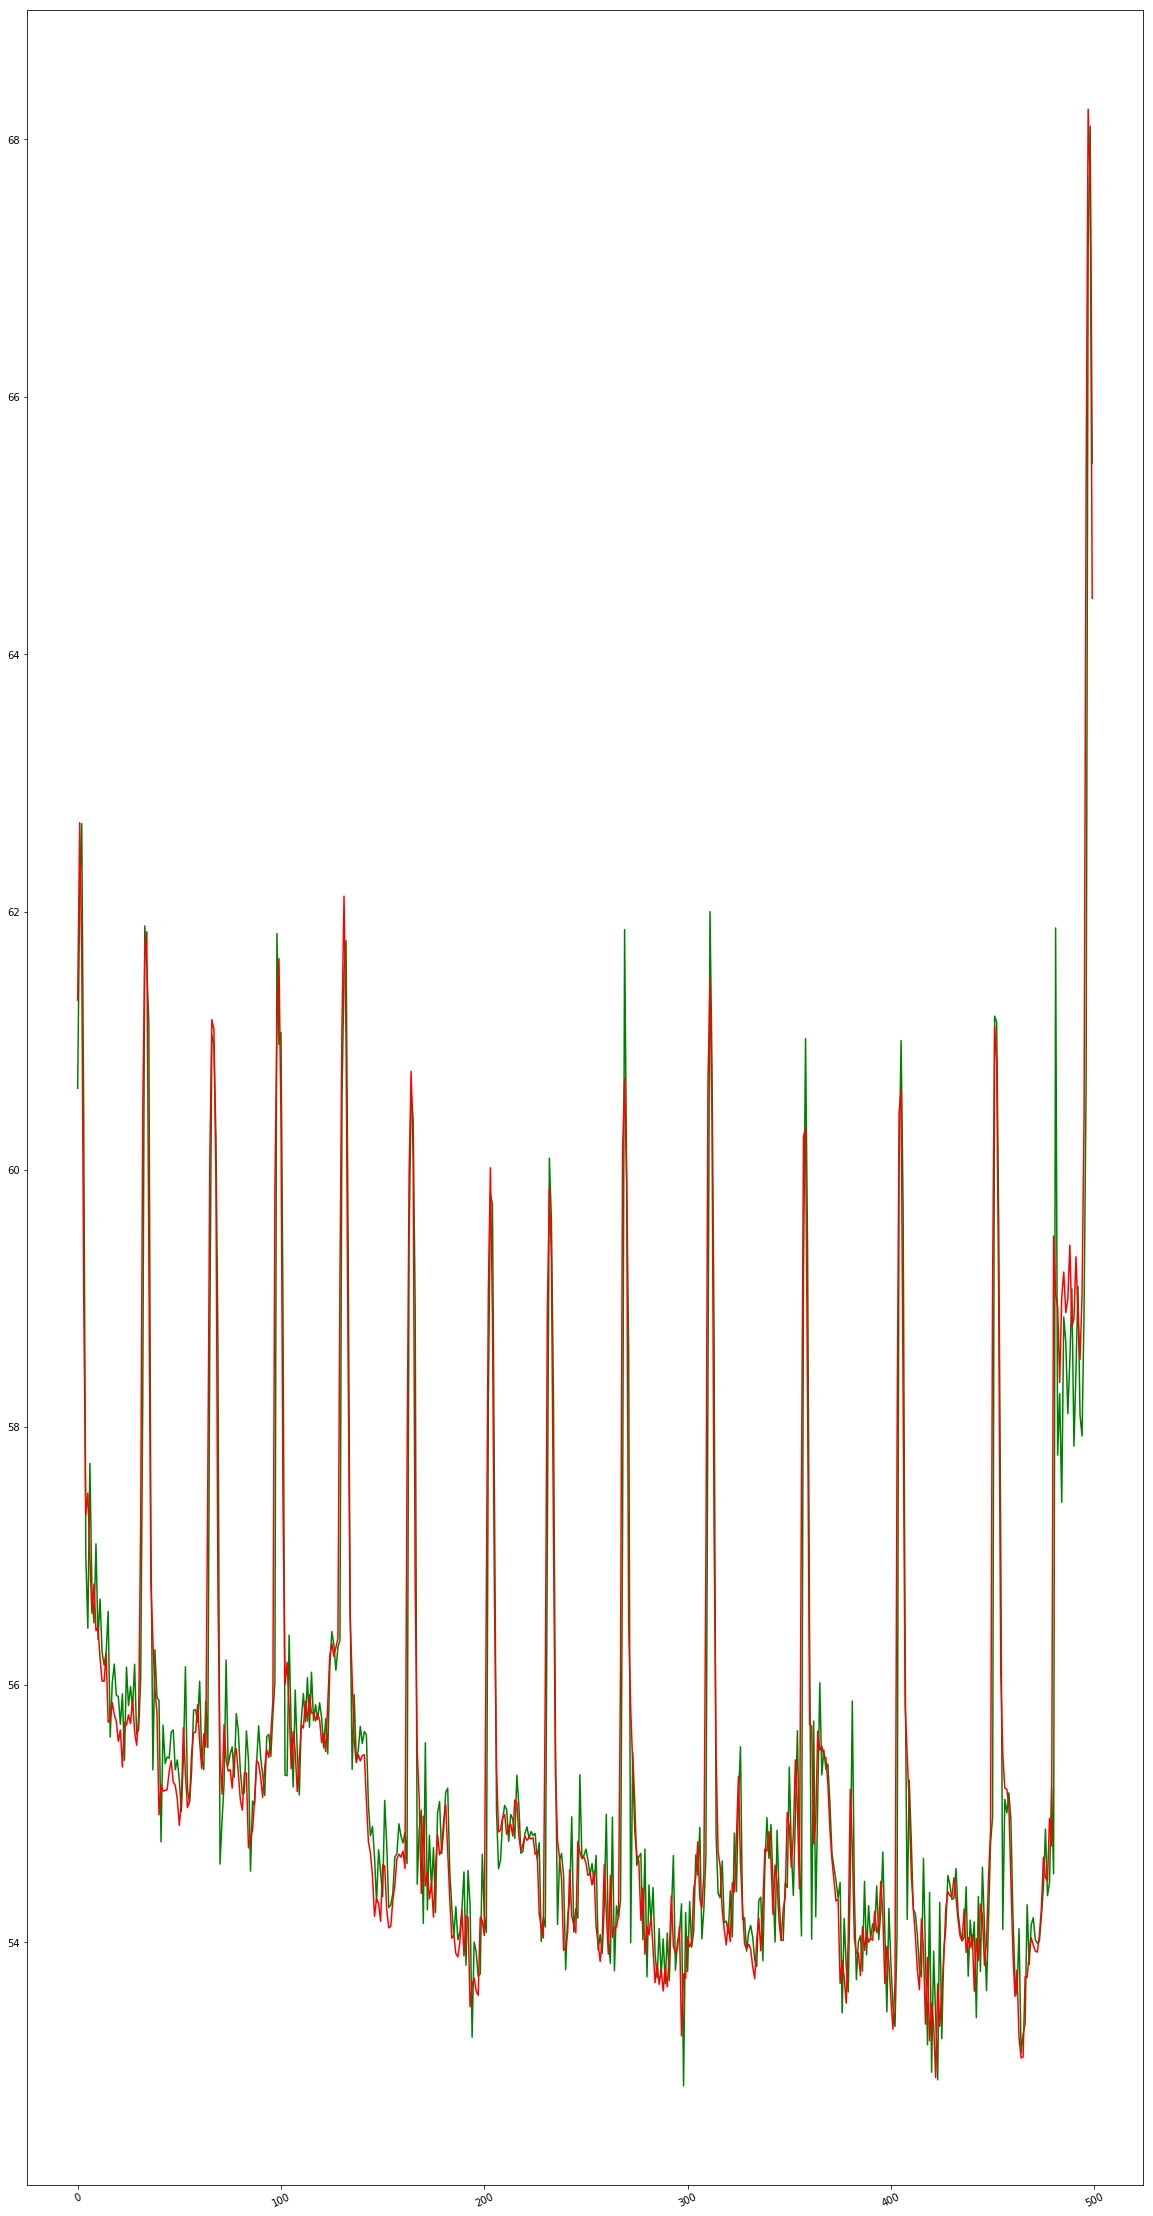

In [45]:
plt.plot(Predictions,color='green')
plt.plot(test_set,color='red')
plt.xticks( rotation=25)
plt.rcParams['figure.figsize'] =(20,40)
plt.show()